In [ ]:
import os
import re
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Embedding
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
import keras
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from google.colab import drive

In [ ]:
#Mount and access drive
drive.mount('/content/drive',force_remount=True)
os.chdir('/content/drive/My Drive')
print("Change successful.")

Mounted at /content/drive
Change successful.
3.Read The Dataset And Do Pre-Processing

In [ ]:
spam_df = pd.read_csv(filepath_or_buffer='/content/spam.csv', delimiter=',',encoding='latin-1')
spam_df.head()

In [ ]:
v1	v2	Unnamed: 2	Unnamed: 3	Unnamed: 4
0	ham	Go until jurong point, crazy.. Available only ...	NaN	NaN	NaN
1	ham	Ok lar... Joking wif u oni...	NaN	NaN	NaN
2	spam	Free entry in 2 a wkly comp to win FA Cup fina...	NaN	NaN	NaN
3	ham	U dun say so early hor... U c already then say...	NaN	NaN	NaN
4	ham	Nah I don't think he goes to usf, he lives aro...	NaN

In [ ]:
#List the column names
spam_df.columns

Index(['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], dtype='object')

In [ ]:
#Drop the unnamed columns
spam_df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1, inplace=True)
spam_df.columns

Index(['v1', 'v2'], dtype='object')

In [ ]:
#Print the number of rows in the dataset
spam_df.shape

(5572, 2)

In [ ]:
#Get the summary statistics of the dataset
spam_df.describe()

In [ ]:
v1	v2
count	5572	5572
unique	2	5169
top	ham	Sorry, I'll call later
freq	4825	30

In [ ]:
#Check for null values
spam_df.isna().sum()

In [ ]:
v1    0
v2    0
dtype: int64

In [ ]:
#Check for duplicated rows
spam_df.duplicated().sum()

403

In [ ]:
#Remove the duplicated rows
spam_df = spam_df.drop_duplicates()
spam_df.duplicated().sum()


0

In [ ]:
#Display the count of spam and ham labels and Stratified-split is required
spam_df['v1'].hist(bins=3)

In [ ]:
def wordcloud_vis(column):
  mostcommon = nltk.FreqDist(spam_df[column]).most_common(100)
  wordcloud = WordCloud(width=1600, height=800, background_color='white').generate(str(mostcommon))
  fig = plt.figure(figsize=(30,10), facecolor='white')
  plt.imshow(wordcloud) #, interpolation="bilinear")
  plt.axis('off')
  plt.show()

In [ ]:
#Plot the word-cloud before removing stopwords, performing lemmatization
wordcloud_vis('v2')

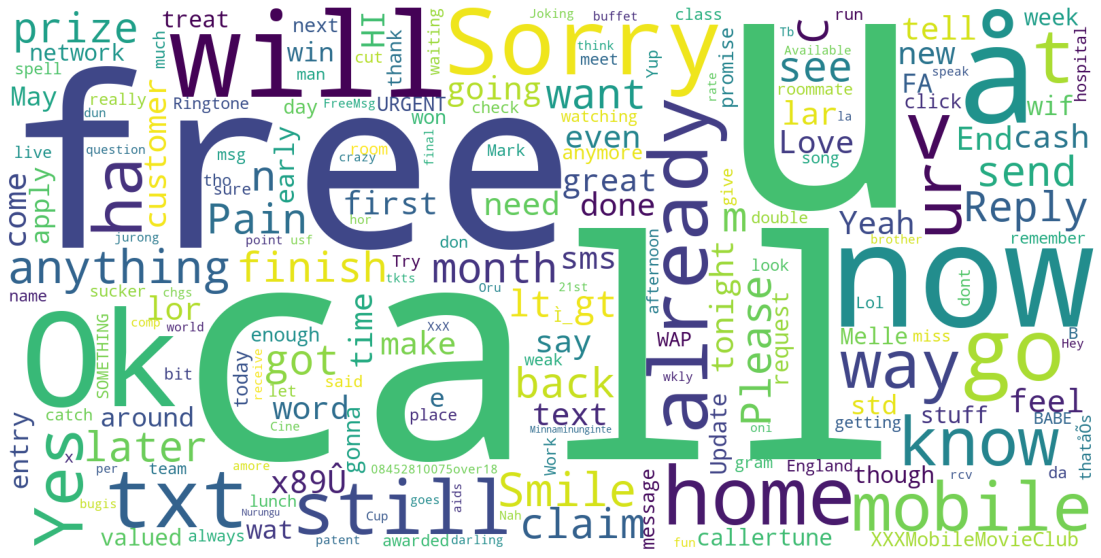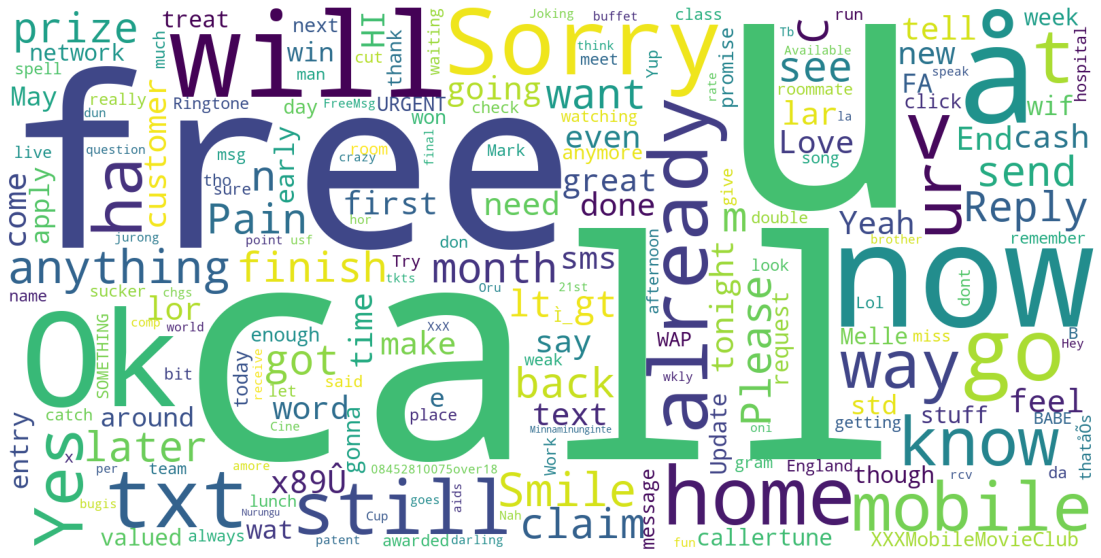

In [ ]:
#Retain only the letters and spaces
spam_df['alpha_text'] = spam_df['v2'].apply(lambda x: re.sub(r'[^a-zA-Z ]+', '', x.lower()))
spam_df.head()

In [ ]:
v1	v2	alpha_text
0	ham	Go until jurong point, crazy.. Available only ...	go until jurong point crazy available only in ...
1	ham	Ok lar... Joking wif u oni...	ok lar joking wif u oni
2	spam	Free entry in 2 a wkly comp to win FA Cup fina...	free entry in a wkly comp to win fa cup final...
3	ham	U dun say so early hor... U c already then say...	u dun say so early hor u c already then say
4	ham	Nah I don't think he goes to usf, he lives aro...	nah i dont think he goes to usf he lives aroun...

In [ ]:
#Remove stop-words
nltk.download('stopwords')
spam_df['imp_text'] = spam_df['alpha_text'].apply(lambda x : ' '.join([word for word in x.split() if not word in set(stopwords.words('english'))]))
spam_df.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.

In [ ]:
v1	v2	alpha_text	imp_text
0	ham	Go until jurong point, crazy.. Available only ...	go until jurong point crazy available only in ...	go jurong point crazy available bugis n great ...
1	ham	Ok lar... Joking wif u oni...	ok lar joking wif u oni	ok lar joking wif u oni
2	spam	Free entry in 2 a wkly comp to win FA Cup fina...	free entry in a wkly comp to win fa cup final...	free entry wkly comp win fa cup final tkts st ...
3	ham	U dun say so early hor... U c already then say...	u dun say so early hor u c already then say	u dun say early hor u c already say
4	ham	Nah I don't think he goes to usf, he lives aro...	nah i dont think he goes to usf he lives aroun...	nah dont think goes usf lives around though

In [ ]:
#Tokenize the data
def tokenize(data):
  generated_token = list(data.split())
  return generated_token
spam_df['token_text'] = spam_df['imp_text'].apply(lambda x: tokenize(x))
spam_df.head()

In [ ]:
#Perform lemmatization
nltk.download('wordnet')
nltk.download('omw-1.4')
lemmatizer = WordNetLemmatizer()
def lemmatization(list_of_words):
  lemmatized_list = [lemmatizer.lemmatize(word) for word in list_of_words]
  return lemmatized_list
spam_df['lemmatized_text'] = spam_df['token_text'].apply(lambda x: lemmatization(x))
spam_df.head()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
v1	v2	alpha_text	imp_text	token_text	lemmatized_text
0	ham	Go until jurong point, crazy.. Available only ...	go until jurong point crazy available only in ...	go jurong point crazy available bugis n great ...	[go, jurong, point, crazy, available, bugis, n...	[go, jurong, point, crazy, available, bugis, n...
1	ham	Ok lar... Joking wif u oni...	ok lar joking wif u oni	ok lar joking wif u oni	[ok, lar, joking, wif, u, oni]	[ok, lar, joking, wif, u, oni]
2	spam	Free entry in 2 a wkly comp to win FA Cup fina...	free entry in a wkly comp to win fa cup final...	free entry wkly comp win fa cup final tkts st ...	[free, entry, wkly, comp, win, fa, cup, final,...	[free, entry, wkly, comp, win, fa, cup, final,...
3	ham	U dun say so early hor... U c already then say...	u dun say so early hor u c already then say	u dun say early hor u c already say	[u, dun, say, early, hor, u, c, already, say]	[u, dun, say, early, hor, u, c, already, say]
4	ham	Nah I don't think he goes to usf, he lives aro...	nah i dont think he goes to usf he lives aroun...	nah dont think goes usf lives around though	[nah, dont, think, goes, usf, lives, around, t...	[nah, dont, think, go, usf, life, around, though]

In [ ]:
#Display the word cloud after preprocessing
wordcloud_vis('clean')

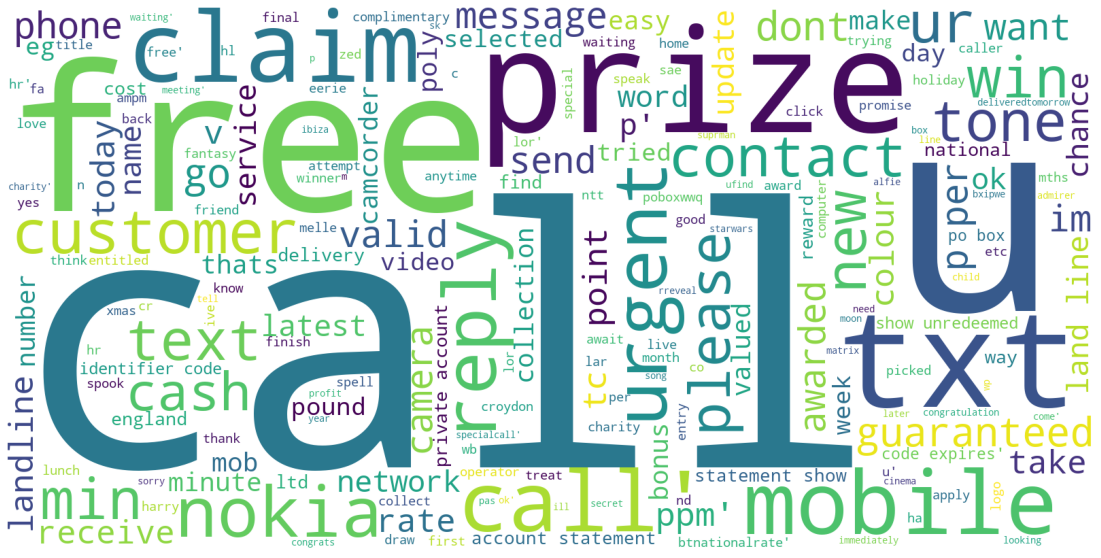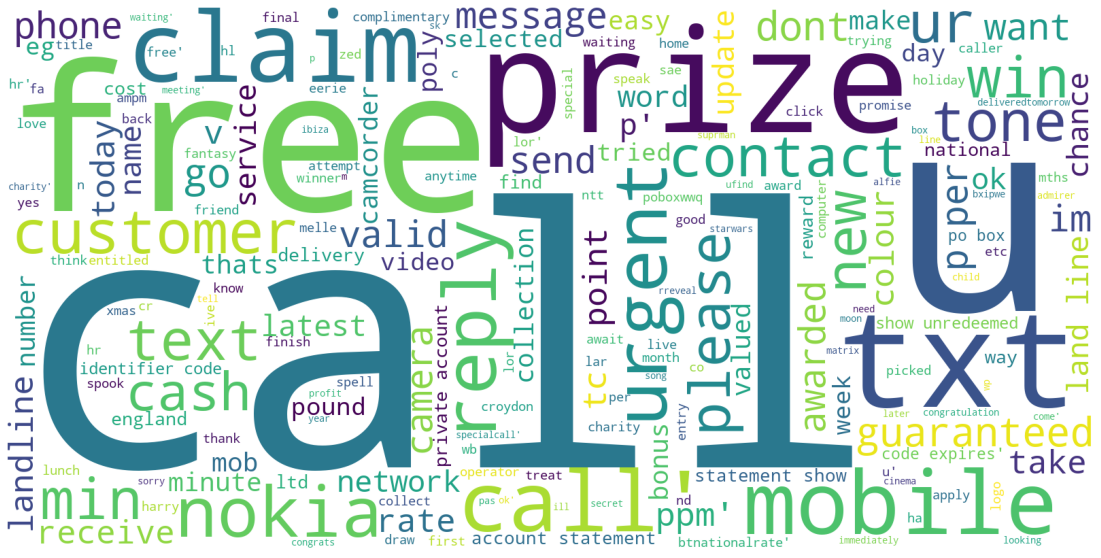

In [ ]:
Save The Model

In [ ]:
model.save('spam-classifier.h5')

In [ ]:
Test The Model


In [ ]:
print("Accuracy of the model on Testing Data is - " , model.evaluate(X_test,y_test

25/25 [==============================] - 1s 24ms/step - loss: 0.1436 - accuracy: 0.9755
Accuracy of the model on Testing Data is -  97.55154848098755 %